<a href="https://colab.research.google.com/github/Travnickt3d/FITLS/blob/main/2024/3_multifeature_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model se všemi features

In [27]:
# Nainstalujeme chybějící knihovny (může trvat déle)
%pip install pandas==2.0.3
%pip install ipympl
%pip install lightning

# Zobrazování
import matplotlib.pyplot as plt

# Práce s daty
import urllib.request, json
import pandas as pd
import numpy as np

# Trénování
import torch
import lightning as L


# Získání datasetu

In [15]:
# Stáhneme dataset
g_dataframe = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/heart.csv")

# Stáhneme info o kódování
with urllib.request.urlopen("https://raw.githubusercontent.com/Travnickt3d/FITLS/main/2024/dataset_info.json") as url:
    g_data_info = json.load(url)

# Třída modelu

In [76]:

class LModel(L.LightningModule):
    def __init__(self, inputs, hidden_units):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(inputs, hidden_units),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(hidden_units, 1),
            torch.nn.Sigmoid()
            )

        self.trn_loss_history = []
        self.val_loss_history = []

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.binary_cross_entropy(y_hat, y)
        error = torch.mean(torch.abs(y_hat - y))
        self.log("[TRAIN LOSS]", loss, prog_bar=True)
        self.log("[TRAIN ERROR]", error, prog_bar=True)
        self.trn_loss_history.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.binary_cross_entropy(y_hat, y)
        error = torch.mean(torch.abs(y_hat - y))
        self.log("[VAL LOSS]", loss, prog_bar=True)
        self.log("[VAL ERROR]", error, prog_bar=True)
        self.val_loss_history.append(loss.item())
        return loss


# Třída datasetu

In [67]:
class AllFeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, data_info):
        self.dataframe = dataframe
        self.data_info = data_info
        self.thal_vals = {"fixed": [1, 0, 0],
                          "normal": [0, 1, 0],
                          "reversible": [0, 0, 1],
                          "0": [1, 0, 0],
                          "1": [0, 1, 0],
                          "2": [0, 0, 1]}

        self.stds = {}
        self.means = {}

        for feature in data_info:
            if g_data_info[feature]["type"] == "numerical":
                self.stds[feature] = self.dataframe[feature].std()
                self.means[feature] = self.dataframe[feature].mean()


    def __len__(self):
        return len(self.dataframe)

    def normalize_numerical(self, feature, value):
        return (value - self.means[feature]) / self.stds[feature]

    def encode_categorical(self, feature, value):
        one_hot = [0] * len(self.data_info[feature]["encoding"])
        one_hot[value] = 1
        return one_hot

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        features = []
        for feature in self.data_info:
            if feature == "target":
                continue
            elif feature == "thal":
                features += self.thal_vals[row[feature]]
            elif self.data_info[feature]["type"] == "numerical":
                features += [self.normalize_numerical(feature, row[feature])]
            else:
                features += self.encode_categorical(feature, row[feature])
        features = torch.tensor(features, dtype=torch.float32)
        target = torch.tensor(row["target"], dtype=torch.float32).unsqueeze(0)
        return features, target

g_val_dataset = AllFeaturesDataset(g_dataframe.sample(frac=0.2, random_state=42000), g_data_info)
g_train_dataset = AllFeaturesDataset(g_dataframe.drop(g_val_dataset.dataframe.index), g_data_info)


# Jak vypadá jeden zakódovaný vzorek
print(g_train_dataset[0])

# for thasample in g_dataframe["thal"]:
#     print(f"{thasample} {type(thasample)}")

(tensor([ 0.8817,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
         0.7231, -0.2982,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0720,
         1.0000,  0.0000,  1.0102,  0.0000,  0.0000,  0.0000,  1.0000, -0.7210,
         1.0000,  0.0000,  0.0000]), tensor([0.]))


# Trénování modelu se všemi features

In [87]:

g_batch_size = 32
g_epochs = 30
g_hidden_units = 32
g_inputs_no = g_train_dataset[0][0].shape[0]

g_model = LModel(g_inputs_no, g_hidden_units)

g_trainer = L.Trainer(max_epochs=g_epochs)

g_train_dataloader = torch.utils.data.DataLoader(g_train_dataset, batch_size=g_batch_size, shuffle=True, drop_last=False)
g_val_dataloader = torch.utils.data.DataLoader(g_val_dataset, batch_size=61)

g_trainer.fit(g_model, g_train_dataloader, g_val_dataloader)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.0 K  | train
---------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.0 K  | train
---------------------------------------------
2.0 K     Trainable params
0         No

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Text(0, 0.5, 'Loss')

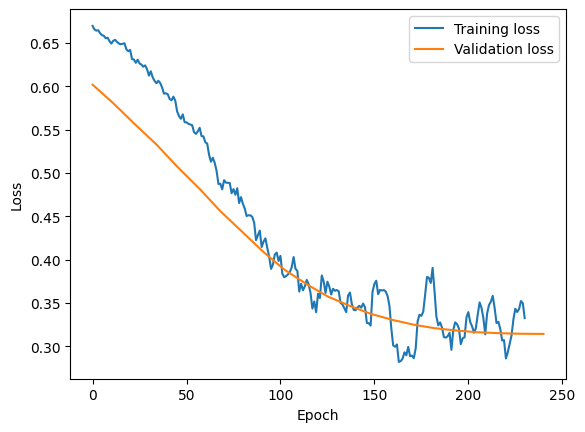

In [89]:
# Vykreslíme historii trénovacícho lossu
loss_history = g_model.trn_loss_history
val_loss_history = g_model.val_loss_history

# Vyhladíme křivky data, aby se lépe četly
window_size = 10
smoothed_loss =  np.convolve(loss_history, np.ones(window_size)/window_size, mode='valid')
smoothed_val_loss =  np.convolve(val_loss_history, np.ones(window_size)/window_size, mode='valid')

val_x_axis_indices = np.linspace(0, len(loss_history), len(smoothed_val_loss)).astype(int)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(smoothed_loss, label='Training loss')
ax.plot(val_x_axis_indices, smoothed_val_loss, label='Validation loss')

ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Používač modelu: TODO

# Závěr: TODO
- TODO: zrevidovat errory - val vs trn vs vse (opravit pro one feature and two features data)